***QuantQuote Free Historical Stock Data***

This collection of daily resolution data goes back to 1998 for all symbols currently active in the S&P500. It is updated quarterly, the last update was 07/31/2013 (for more frequent updates, contact us). While this data is available for free from multiple online sources, the QuantQuote Free Daily Data has several advantages not found elsewhere:

***Full split/dividend adjustments for OHLCV***

Single zip file makes downloading ~500 symbols a one step process

QuantQuote data quality means errors in many free sources (such as Yahoo) are not present.

For format information, please consult our minute resolution data documentation.

Our active S&P500 daily resolution collection is provided completely free of charge and because of that, it is not covered under our lifetime support gauranty. Data is provided as is, with no warranty. However, if you do have questions about the data or find errors, please feel free to reach out to our support team at support@quantquote.com.

Happy trading,

The QuantQuote Team

***Splits***

When a stock split occurs, the data is adjusted to reflect this so that the data is more or less continuous. If the stock price is 20 and then a 2:1 split occurs, bringing the price to 10, all data ***before the split date*** is divided by 2. The split factor data column is then multiplied by 2. The data thus reflects how much money an investor would expect to make by investing at the beginning of a period and selling at the end of the period without having to take split discontinuities into account. The true price of the stock on any day can be recovered by multiplying the listed price by the split factor. The open, high, low, close, volume, and dividend columns are all split-adjusted.   ***[In other words, the price shown is the price as if all splits had already occurred]***

In [393]:
import os
import pandas as pd
import requests
import re
import itertools
import time
import pickle
import numpy as np
#from IPython.core.display import HTML
from bs4 import BeautifulSoup
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt

import datetime
import dateutil.parser
import random

def norm_series_by_end_cap(s, market_cap):
    return s * market_cap / s.iloc[-1]

def ltif(a, b):
    if a == None or b == None:
        return True
    else:
        return a < b
    
def gtif(a, b):
    if a == None or b == None:
        return True
    else:
        return a > b

class StockData:

    def __init__(self):
        self.stocks = dict()
        self.sectors = dict()
        self.industries = dict()
        self.market_caps = dict()
        self.market_caps_rel = dict()
        self.names = dict()
        self.sectoravg = dict()
        self.sectorgroup = dict()
        self.hits = dict()
        self.growth_ratio = dict()

    # Setting end_stock = None will use all stocks in the S&P 500
    def create(self, base="/Users/joshuavonkorff/K2/2 - Exploring Data/9 - Project 2",\
                 pathpart = "/quantquote_daily_sp500_83986/daily",\
                 single_stock = None,\
                 begin_stock = 0,\
                 end_stock = 1,\
                 use_NYT = True):
        '''Create StockData object:
        (1) Read all stock names from Quant Quote file.
        [In 2-5, the number of stocks is limited to begin_stock through end_stock - 1]
        (2) Read sector and industry information from Fidelity website
        (3) Read market cap 2018 from Fidelity website
        (4) Read number of NYT hits for each stock
        (5) Calculate growth ratio for each stock
        (6) Calculate average stock data by sector
        (7) Calculate market caps relative to average'''
        os.chdir(base)
        path = base + pathpart
        os.chdir(path)
        
        quantquote_filelist = os.listdir(path=path)
        
        # (1)
        for filename in quantquote_filelist:
            if filename[-7:] == ".pickle":
                continue
            stock_code = filename.split(".")[0].split("_")[1]
            self.stocks[stock_code] = pd.read_csv(filename, header=None, parse_dates=[0])
            self.stocks[stock_code].columns = ['DATE', 'TIME', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME']
            
        # (2) & (3)
        if single_stock:
            stocklist = [single_stock]
        else:
            stocklist = itertools.islice(self.stocks.keys(), begin_stock, end_stock)
        stocknum = 0
        for stock in stocklist:
            stockupper = stock.upper()
            fidelitypage = "https://eresearch.fidelity.com/eresearch/evaluate/snapshot.jhtml?symbols=" + stockupper
            print("Reading stock: " + stockupper + ", which is number: " + str(stocknum))
            stocknum += 1
            page = requests.get(fidelitypage)
            soup = BeautifulSoup(page.content, 'html.parser')
            time.sleep(2)
            lst = list()
            # (2)
            for x in soup(text=re.compile(r"\(GICS")):
                lst.append(x.parent.next_sibling.contents[0].contents[0])
            try:
                sector, industry = lst
                # print(f"Stock {stockupper} has sector '{sector}' and industry '{industry}.'")
                self.sectors[stock] = str(sector)
                self.industries[stock] = str(industry)
            except ValueError:
                print(f"Cannot find stock {stockupper} on Fidelity website.")
            # (3)
            for x in soup(text=re.compile(r"Market Capitalization")):
                market_cap = x.parent.next_sibling.contents[0]
                try:
                    market_cap = market_cap.strip('$')
                    if market_cap[-1] == 'B':
                        market_cap = float(market_cap.strip().strip('B')) * 1000000000
                    elif market_cap[-1] == 'M':
                        market_cap = float(market_cap.strip().strip('M')) * 1000000
                    elif market_cap[-1] == 'K':
                        market_cap = float(market_cap.strip().strip('K')) * 1000
                    else:
                        market_cap = int(market_cap)
                    # print("Market cap is: ", market_cap)
                    self.market_caps[stock] = float(market_cap)
                except:
                    print(f"Cannot get market capitalization for stock {stockupper} on Fidelity website.")
                try:
                    self.names[stock] = str(soup.find(id="companyName").contents[0])
                    # print(f"Name of company: {names[stock]}")
                except:
                    print(f"Cannot get name for stock {stockupper} on Fidelity website.")
            # (4)
            if use_NYT:
                self.hits[stock] = self.get_hits(stock)
                hitdict[stock] = self.hits[stock]
            else:
                try:
                    self.hits[stock] = hitdict[stock]
                except:
                    self.hits[stock] = None
            # (5)
            self.growth_ratio[stock] = self.stocks[stock]['CLOSE'].iloc[-1] / self.stocks[stock]['CLOSE'].iloc[0]
            
        # (6)
        
        # stocks must be sorted or groupby won't work
        sortedstocks = sorted(self.sectors.keys(), key = lambda x: self.sectors[x])

        for sector, group in itertools.groupby(sortedstocks, lambda x: self.sectors[x]):
            grouplist = list(group)
            self.sectorgroup[sector] = grouplist
            sectordf = pd.concat(list(norm_series_by_end_cap(self.stocks[stock][['DATE', 'CLOSE']].set_index('DATE'),\
                                                             self.market_caps[stock])\
                                      for stock in grouplist), axis=1)
            self.sectoravg[sector] = sectordf.mean(axis=1)
            
        # (7)
        
        if single_stock:
            stocklist = [single_stock]
        else:
            stocklist = itertools.islice(self.stocks.keys(), begin_stock, end_stock)
        for stock in stocklist:
            lst = self.market_caps.values()
            try:
                self.market_caps_rel[stock] = self.market_caps[stock] / (sum(lst) / len(lst))
            except:
                pass
            
    def get_market_cap(self, stock, datestring):
        '''
        Find the market cap of the stock at the given date string.
        If the stock closing price is not known at the given date,
        try 10 days forward and 10 days back from that date.'''
        try:
            market_cap2018 = self.market_caps[stock]
        except KeyError:
            return None
        daydelta = datetime.timedelta(days=1)
        date = dateutil.parser.parse(datestring)
        s = self.stocks[stock][['DATE', 'CLOSE']].set_index('DATE')
        for n in range(10):
            try:
                cap = s.loc[date]['CLOSE'] * market_cap2018 / s.iloc[-1]['CLOSE']
                return cap
            except:
                date += daydelta
        date -= daydelta * 10
        for n in range(10):
            try:
                cap = s.loc[date]['CLOSE'] * market_cap2018 / s.iloc[-1]['CLOSE']
                return cap
            except:
                date -= daydelta
        return None

    def get_average_market_cap(self, datestring):
        '''
        Find the average market cap over all stocks whose market cap is known at (or around) the given date.
        Returns a list of: (0) the average, (1) the total, (2) the number of known market caps at this date.
        If no caps are known at (or around) this date, return zero.
        '''
        total_cap = 0
        num_caps = 0
        for stock in self.stocks.keys():
            cap = self.get_market_cap(stock, datestring)
            if cap:
                total_cap += cap
                num_caps += 1
        if total_cap > 0:
            return [total_cap / num_caps, total_cap, num_caps]
        else:
            return None

    def get_cap_ratio(self, stock, datestring = None):
        if not datestring:
            try:
                return self.market_caps[stock]\
                      / self.get_average_market_cap('20130701')[0]
            except:
                return None
        else:
            print(f"In datestring in get_cap_ratio for stock {stock}")
            try:
                return self.get_market_cap(stock, datestring)\
                      / self.get_average_market_cap(datestring)[0]
            except:
                return None
        
    def get_hits(self, stock):
        try:
            dates, hits = get_dates_and_hits(api, q='"' + self.names[stock] + '"', fl="web_url,pub_date", nmax = 10, \
                                  begin_date=self.stocks[stock].set_index('DATE').index[0].strftime("%Y%m%d"), \
                                  end_date=self.stocks[stock].set_index('DATE').index[-1].strftime("%Y%m%d"))
        except (KeyError, IndexError):
            print(f"Can't get NYT hits for stock {stock}")
            hits = None
        return hits
        
    def plot_stock(self, stock, rel = False):
        s = norm_series_by_end_cap(self.stocks[stock][['DATE', 'CLOSE']].set_index('DATE')['CLOSE'], self.market_caps[stock])
        if rel:
            s /= self.get_average_market_cap('20130701')[0]

        plt.figure()
        s.plot()
        plt.gca().set_title(stock)
                    
    def plot_sector(self, sector, rel = False):
        s = self.sectoravg[sector].copy()
        if rel:
            s /= self.get_average_market_cap('20130701')[0]
        
        plt.figure()
        ax = s.plot(y='CLOSE')
        ax.set_title(sector)
        print(self.sectorgroup[sector])

    def plot_growth(self, stock):
        plt.figure()
        stocks[stock].plot(x='DATE', y='CLOSE')
        print(f"From 1998 to 2013, '{stock}' grew by {growth_ratio(stock)}")
        plt.gca().set_title(stock)

    def plot_caps_vs_hits(self, rel = False, sector = None, xmin = None, xmax = None, ymin = None, ymax = None):
        if rel:
            capdict = self.market_caps_rel
        else:
            capdict = self.market_caps
        if sector:
            common_keys = [k for k in capdict.keys() if k in self.hits.keys() and self.hits[k] is not None and k in self.sectors.keys() and self.sectors[k] == sector]
        else:
            common_keys = [k for k in capdict.keys() if k in self.hits.keys() and self.hits[k] is not None]
        x = np.array([capdict[k] for k in common_keys if gtif(capdict[k], xmin) and ltif(capdict[k], xmax) and gtif(self.hits[k], ymin) and ltif(self.hits[k], ymax)])
        y = np.array([self.hits[k] for k in common_keys if gtif(capdict[k], xmin) and ltif(capdict[k], xmax) and gtif(self.hits[k], ymin) and ltif(self.hits[k], ymax)])

        plt.plot(x, y, 'bo')
        b, m = polyfit(x, y, 1)
        plt.plot(x, b + x * m, '-')
        plt.xlabel('Final market cap')
        plt.ylabel('Number of mentions in NYT')
        
    def plot_growth_vs_hits(self, sector = None, xmin = None, xmax = None, ymin = None, ymax = None):
        if sector:
            common_keys = [k for k in self.growth_ratio.keys() if k in self.hits.keys() and self.hits[k] is not None and k in self.sectors.keys() and self.sectors[k] == sector]
        else:
            common_keys = [k for k in self.growth_ratio.keys() if k in self.hits.keys() and self.hits[k] is not None]
        x = np.array([self.growth_ratio[k] for k in common_keys if gtif(self.growth_ratio[k], xmin) and ltif(self.growth_ratio[k], xmax) and gtif(self.hits[k], ymin) and ltif(self.hits[k], ymax)])
        y = np.array([self.hits[k] for k in common_keys if gtif(self.growth_ratio[k], xmin) and ltif(self.growth_ratio[k], xmax) and gtif(self.hits[k], ymin) and ltif(self.hits[k], ymax)])

        plt.plot(x, y, 'bo')
        b, m = polyfit(x, y, 1)
        plt.plot(x, b + x * m, '-')
        plt.xlabel('Growth (market cap ratio), 1998-2013')
        plt.ylabel('Number of mentions in NYT')        

    def plot_caps_vs_growth(self, rel = False, sector = None, xmin = None, xmax = None, ymin = None, ymax = None):
        if rel:
            capdict = self.market_caps_rel
        else:
            capdict = self.market_caps
        if sector:
            common_keys = [k for k in capdict.keys() if k in self.growth_ratio.keys() and self.growth_ratio[k] is not None and k in self.sectors.keys() and self.sectors[k] == sector]
        else:
            common_keys = [k for k in capdict.keys() if k in self.growth_ratio.keys() and self.growth_ratio[k] is not None]
        x = np.array([capdict[k] for k in common_keys if gtif(capdict[k], xmin) and ltif(capdict[k], xmax) and gtif(self.growth_ratio[k], ymin) and ltif(self.growth_ratio[k], ymax)])
        y = np.array([self.growth_ratio[k] for k in common_keys if gtif(capdict[k], xmin) and ltif(capdict[k], xmax) and gtif(self.growth_ratio[k], ymin) and ltif(self.growth_ratio[k], ymax)])

        plt.plot(x, y, 'bo')
        b, m = polyfit(x, y, 1)
        plt.plot(x, b + x * m, '-')
        plt.xlabel('Final market cap')
        plt.ylabel('Growth (market cap ratio), 1998-2013')        

    def print_table(self, sector = None, sortby = 0, reverse = False):
        '''
        sortby = 0: sort by symbol
        sortby = 1: sort by market cap
        sortby = 2: sort by relative market cap
        sortby = 3: sort by growth ratio
        sortby = 4: sort by hits'''
        print("Stock, market cap, relative market cap, growth ratio, hits")
        if sector:
            lst = [k for k in self.stocks.keys() if k in self.sectors.keys() and self.sectors[k] == sector]
        else:
            lst = self.stocks.keys()
        rows = list()
        for k in lst:
            row = list()
            include = False
            try:
                row.append(k + ": " + str(self.names[k]) + ": ")
            except:
                row.append(k + ": ")
            try:
                row.append(self.market_caps[k])
                include = True
            except:
                row.append(None)
            try:
                row.append(self.market_caps_rel[k])
                include = True
            except:
                row.append(None)
            try:
                row.append(self.growth_ratio[k])
                include = True
            except:
                row.append(None)
            try:
                row.append(self.hits[k])
                include = True
            except:
                row.append(None)
            if include:
                rows.append(row)
        rows.sort(key = lambda x: x[sortby] if x[sortby] is not None else 0, reverse = reverse)
        for row in rows:
            print(row[0], row[1], row[2], row[3], row[4])
        
    def pickle(self, filename = None):
        if not filename:
            filename = "data"
        with open(filename + ".pickle", 'wb') as f:
            pickle.dump(self, f, pickle.HIGHEST_PROTOCOL)
    
    def picklehits(self, filename = None):
        if not filename:
            filename = "hits"
        with open(filename + ".pickle", 'wb') as f:
            pickle.dump(hitdict, f, pickle.HIGHEST_PROTOCOL)
            
    def __str__(self):
        return f"Num stocks = {len(self.stocks.keys())}, Num sectors = {len(self.sectors.keys())}, " +\
               f"Num industries = {len(self.industries.keys())}, Num market_caps = {len(self.market_caps.keys())}, " +\
               f"Num names = {len(self.names.keys())}, Num sectoravgs = {len(self.sectoravg.keys())}, " +\
               f"Num sectorgroup = {len(self.sectorgroup.keys())}, Num hits = {len(self.hits.keys())}, " +\
               f"Num growth_ratio = {len(self.growth_ratio.keys())}"   

def unpickle_StockData(filename = None):
    if not filename:
        filename = 'data'
    with open(filename + ".pickle", 'rb') as f:
        return pickle.load(f)
    
def unpickle_hitdict(filename = None):
    if not filename:
        filename = 'hits'
    with open(filename + ".pickle", 'rb') as f:
        return pickle.load(f)
        
def list_sectors(self):
    print(list(set(sectors.values())))

In [261]:
# There was a bug in the New York Times Python code so I obtained the code from GitHub and fixed it. 
# It is a short piece of code.  The problem was that some unicode strings were being printed prefixed with a "b"
# which was inserted into the URL of the GET request, making the terms unrecognizable.  I had to decode
# the unicode back into ASCII.

import requests

API_ROOT = 'http://api.nytimes.com/svc/search/v2/articlesearch.'

API_SIGNUP_PAGE = 'http://developer.nytimes.com/docs/reference/keys'

class NoAPIKeyException(Exception):
    def __init__(self, value):
        self.value = value
    def __str__(self):
        return repr(self.value)

class articleAPI(object):
    def __init__(self, key = None):
        """
        Initializes the articleAPI class with a developer key. Raises an exception if a key is not given.
        
        Request a key at http://developer.nytimes.com/docs/reference/keys
        
        :param key: New York Times Developer Key
        
        """
        self.key = key
        self.response_format = 'json'
        
        if self.key is None:
            raise NoAPIKeyException('Warning: Missing API Key. Please visit ' + API_SIGNUP_PAGE + ' to register for a key.')
    
    def _utf8_encode(self, d):
        """
        Ensures all values are encoded in UTF-8 and converts them to lowercase
        
        """
        for k, v in d.items():
            if isinstance(v, str):
                d[k] = v.encode('utf8').lower()
                d[k] = d[k].decode("utf-8") # I am not sure why it utf-8 encoded this
                                            # But I had to undo it or there would be a "b" in front of the string
            if isinstance(v, list):
                for index,item in enumerate(v):
                    item = item.encode('utf8').lower()
                    item = item.decode("utf-8")
                    v[index] = item
            if isinstance(v, dict):
                d[k] = self._utf8_encode(v)
        return d
    
    def _bool_encode(self, d):
        """
        Converts bool values to lowercase strings
        
        """
        for k, v in d.items():
            if isinstance(v, bool):
                d[k] = str(v).lower()
        
        return d

    def _options(self, **kwargs):
        """
        Formats search parameters/values for use with API
        
        :param \*\*kwargs: search parameters/values
        
        """
        def _format_fq(d):
            for k,v in d.items():
                if isinstance(v, list):
                    d[k] = ' '.join(map(lambda x: '"' + x + '"', v))
                else:
                    d[k] = '"' + v + '"'
            values = []
            for k,v in d.items():
                value = '%s:(%s)' % (k,v)
                values.append(value)
            values = ' AND '.join(values)
            return values

        kwargs = self._utf8_encode(kwargs)
        kwargs = self._bool_encode(kwargs)
        values = ''
        
        for k, v in kwargs.items():
            if k is 'fq' and isinstance(v, dict):
                v = _format_fq(v)
            elif isinstance(v, list):
                v = ','.join(v)
            values += '%s=%s&' % (k, v)

        return values

    def search(self, 
                response_format = None, 
                key = None, 
                **kwargs):
        """
        Calls the API and returns a dictionary of the search results
        
        :param response_format: the format that the API uses for its response, 
                                includes JSON (.json) and JSONP (.jsonp). 
                                Defaults to '.json'.
                                
        :param key: a developer key. Defaults to key given when the articleAPI class was initialized.
        
        """
        if response_format is None:
            response_format = self.response_format
        if key is None:
            key = self.key
        
        url = '%s%s?%sapi-key=%s' % (
            API_ROOT, response_format, self._options(**kwargs), key
        )
        
        r = requests.get(url)
        return r.json()

In [233]:
# Notes on NYT API queries:

# NYTimes API specs: https://github.com/NYTimes/public_api_specs
# Python wrapper for API: https://pypi.org/project/nytimesarticle/0.1.0/
# wrapper code: https://github.com/MattDMo/NYTimesArticleAPI/blob/master/NYTimesArticleAPI/search_api.py
# Try it out online: https://developer.nytimes.com/article_search_v2.json#/Console/GET/articlesearch.json
# My key: 45c1113ac6434ecba03ac3c68cc1d71e

# Note: each keyword argument must be passed as a single string, contrary to what the Python API pages say.
# Use Lucene Query Syntax: http://www.lucenetutorial.com/lucene-query-syntax.html

# When you search, the search term "q" will be searched throughout the body of the articles.  That means you can't
# always tell by reading the response where the search term occurred (because you don't get to see the article)
# The lead_paragraph keyword appears to have been disabled, or else I just haven't found which articles it works with.
# Maybe old articles?

#from nytimesarticle import articleAPI

import requests
import IPython.display
import sqlite3
import time
#from IPython.core.display import HTML
from bs4 import BeautifulSoup

class NYTsearch:    
    def __init__(self, api, maxart = 1, get_html = False, verbose = False, sleeptime = 0, **kwargs):
        self.keywords = kwargs
        if sleeptime > 0:
                time.sleep(sleeptime)
        self.articles = api.search(**self.keywords)
        #print(self.articles)
            
        self.web_url = []
        self.snippet = []
        self.author = []
        self.headline = []
        self.news_desk = []
        self.pub_date = []
        self.titlehtml = []
        self.bodyhtml = []
        self.message = "No message"
        self.hits = 0

        try:
            if self.articles['message'] == "API rate limit exceeded":
                self.numart = 0
                self.message = "API rate limit exceeded"
                return
        except:
            pass
        
        self.numart = min([maxart, len(self.articles['response']['docs'])])
    
        try:
            self.hits = self.articles['response']['meta']['hits']
        except:
            self.hits = None
    
        for n in range(0, self.numart):
            try:
                art = self.articles['response']['docs'][n]
                if verbose:
                    print(art)
            except KeyError:
                break
            try:
                self.web_url.append(art['web_url'])
            except KeyError:
                self.web_url.append("")
            try:
                self.snippet.append(art['snippet'])
            except KeyError:
                self.snippet.append("")
            try:
                self.author.append(art['byline']['person'][0]['firstname'] + " " + art['byline']['person'][0]['lastname'])
            except (KeyError, IndexError):
                self.author.append("")
            try:
                self.headline.append(art['headline']['main'])
            except KeyError:
                self.headline.append("")
            try:
                self.news_desk.append(art['new_desk']) # typo in NYT api, it really says new_desk
            except KeyError:
                self.news_desk.append("")
            try:
                self.pub_date.append(art['pub_date'])
            except KeyError:
                self.pub_date.append("")
            titlehtmllst = 0
            bodyhtmllst = 0
            if get_html:
                try:
                    page = requests.get(self.web_url[n])
                    soup = BeautifulSoup(page.content, 'html.parser')
                    #print(soup.prettify())
                    titlehtmllst = soup.find_all('h1')
                    bodyhtmllst = soup.find_all('article')
                    #bodyhtmllst = soup.find_all('p', class_='css-1cy1v93 e2kc3sl0')
                except IndexError:
                    pass
            if titlehtmllst == 0:
                self.titlehtml.append("")
            else:
                self.titlehtml.append(''.join(list(map(str, titlehtmllst))))
            if bodyhtmllst == 0:
                self.bodyhtml.append("")
            else:
                self.bodyhtml.append(''.join(list(map(str, bodyhtmllst))))
            
    def __str__(self):
        result = ""
        for n in range(0, self.numart):
            result += "For article " + str(n) + ":\n"
            try:
                result += "web_url: " + self.web_url[n] + "\n"
            except IndexError:
                pass
            try:
                result += "snippet: " + self.snippet[n] + "\n"
            except IndexError:
                pass
            try:
                result += "author: " + self.author[n] + "\n"
            except IndexError:
                pass
            try:
                result += "headline: " + self.headline[n] + "\n"
            except IndexError:
                pass
            try:
                result += "news desk: " + self.news_desk[n] + '\n'
            except IndexError:
                pass
            try:
                result += "pub date: " + self.pub_date[n] + '\n'
            except IndexError:
                pass
        return result
        
    def display(self, n):
        try:
            IPython.display.display_html(self.titlehtml[n] + self.bodyhtml[n], raw=True)
        except IndexError:
            print("No results found.")

api = articleAPI('You need to obtain your own API key')

def get_dates_and_hits(api, q, fl, begin_date=None, end_date=None, nmax=10):
    page = 0
    dates = []
    while 1:
        print(f"At page: {page}0-{page}9")
        search_result = NYTsearch(api, maxart=10, q=q, fl=fl, begin_date=begin_date, end_date=end_date, page=page, sleeptime=2)
        page += 1
        #print("Result is: ", search_result)
        if (search_result.numart == 0):
            print("Result has no articles")
            print(search_result.message)
            break
        else:
            for d in search_result.pub_date:
                #print(d.split("T")[0])
                dates.append(d.split("T")[0])
        if page * 10 >= nmax:
            break
    return [dates, search_result.hits]

The command below will initialize a StockData object, setting all of its dictionaries to be empty dictionaries.  It will not read any data into the object.

In [298]:
#sd = StockData() - Do not run this command

The command below will create a StockData object, extracting hit counts from the New York Times website and name and sector information from the Fidelity website.  Note that there is a limit to the number of New York Times queries that can be made per day (probably 1,000), while there are 500 stocks in this set.  So be careful about overdoing it with this kind of query.  The hit information is saved in the global hitdict dictionary, which can be pickled using sd.picklehits().  If you then call create with use_NYT = False, it will take the hits from the hitdict dictionary.  This potentially helps to conserve the scarce query resources.

In [ ]:
#sd.create(begin_stock = 0, end_stock = None, use_NYT = True) - Do not run this command

hitdict is 383 long whereas there are 500 stocks in the S & P 500.  That means that some stocks could not be found in the Fidelity website.  A likely reason for this is that the stock symbol changed since 2013.  Without finding them on the Fidelty website, we do not know the corporation's name and we cannot search for that corporation on the New York Times API.

In [389]:
hitdict = unpickle_hitdict()
print(len(hitdict))

383


The stock data have already been pickled and stored.

In [394]:
sd = unpickle_StockData()

We can make three kinds of plots, comparing three different quantities: (1) "caps", the market caps for each stock in 2018, i.e. the total value of the company, (2) "growth", the growth ratio, the cap in 2013 divided by the cap in 1998, and (3) "hits", the number of hits on the NY Times website.  Note that only the official company name, according to Fidelity, was searched for on the NY Times website.  This, however, is not a bad thing, since the NY Times usually includes meta data on any page that stores the company's official name.

xmax and ymax are set to remove outliers.  In both of the graphs below, we can see that there is a correlation between the size of the company in 2018 and the number of references made to that company in the New York Times.  

Note that the final (2018) market cap is shown in dollars, in units of 1e11 or $100 billion.  If you include the keyword rel = True, it will show the cap in relative units, where one unit is the average 2018 market cap of all stocks in the S & P 500.

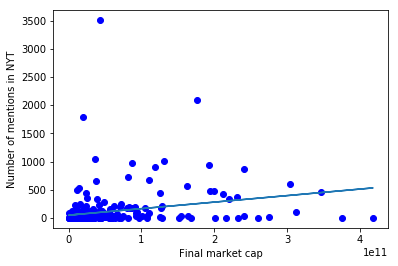

In [391]:
sd.plot_caps_vs_hits(xmax = 0.5 * 1e12, ymax = 5000)
#sd.plot_caps_vs_hits()

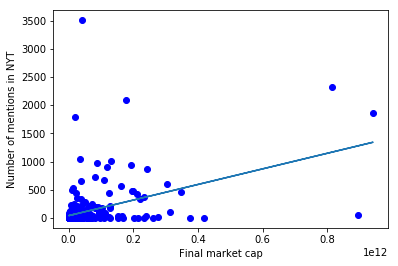

In [334]:
sd.plot_caps_vs_hits(ymax = 5000)

There does not appear to be a correlation between market cap and growth.

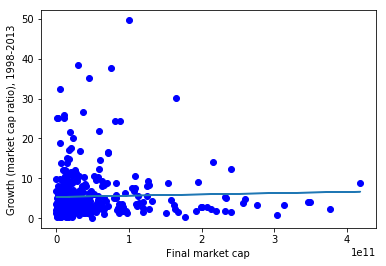

In [396]:
sd.plot_caps_vs_growth(xmax = 0.6 * 1e12, ymax = 100)

If anything, there is a negative correlation between growth and hits.  I think this indicates that NYT does not selectively report on a stock's growth, but on both growth and decline.  Or, perhaps it means that NYT readership does not care about growth at all, only on whether the stock affects their daily lives.  For instance, it may be that articles about Microsoft are more about Microsoft's products than about the rise or fall of Microsoft stock.  In the next item, let's look at some of the fast growing stocks and see what they are doing.

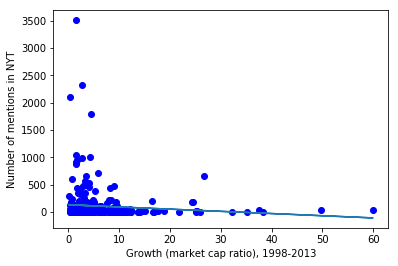

In [401]:
sd.plot_growth_vs_hits(xmax = 100, ymax = 5000)

Here is a table of all of the stocks sorted by growth ratio.  The highest growth ratio is that of Monster Beverage Corporation, which grew by a factor of 573 over the period 1998-2013.  This likely means that its initial public offering occurred during that time period, and it grew rapidly after that.  Monster is followed by Celgene, Cognizant

In [375]:
sd.print_table(sortby = 3, reverse = True)


Stock, market cap, relative market cap, growth ratio, hits
mnst: MONSTER BEVERAGE CORPORATION:  34980000000.0 0.6968703464206417 572.9438202247192 4
celg: CELGENE CORPORATION:  62230000000.0 1.2397439010221993 197.50655620538234 None
ctsh: COGNIZANT TECHNOLOGY SOLUTIONS CORPORATION:  48480000000.0 0.9658168780581106 175.5118595905123 11
aapl: APPLE INC:  941000000000.0 18.746569353396907 115.00184764286328 1856
amzn: AMAZON COM:  894720000000.0 17.824580799013052 59.9798722553763 44
gild: GILEAD SCIENCES INC:  100380000000.0 1.99976687746438 49.644025399268806 28
alxn: ALEXION PHARMACEUTICALS INC:  30350000000.0 0.6046316470516431 38.41414141414141 2
biib: BIOGEN INC:  74900000000.0 1.4921552014552906 37.56543668137738 35
esrx: EXPRESS SCRIPTS HOLDING COMPANY:  44870000000.0 0.8938985833017208 35.24713038678219 0
srcl: STERICYCLE INC:  5760000000.0 0.11475052016532007 32.29241379310345 3
nflx: NETFLIX INC:  164960000000.0 3.286327396956805 30.11575178997613 None
ebay: EBAY INC:  375800

cost: COSTCO WHOLESALE CORPORATION:  94290000000.0 1.8784421087479217 6.267149658904808 98
fdo:  None None 6.213918063573764 None
afl: AFLAC INC:  33240000000.000004 0.662206126787368 6.211506123693151 19
el: ESTEE LAUDER COMPANIES INC:  52190000000.0 1.0397273693451483 6.0494309356634846 9
nue: NUCOR CORPORATION:  20560000000.0 0.4095956067012119 5.985890227870024 34
disca: DISCOVERY INC:  4120000000.0 0.08207849706269421 5.959656824768299 2
cop: CONOCOPHILLIPS:  82230000000.0 1.6381832071517828 5.9212916603897305 718
fcx: FREEPORT MCMORAN INC:  24300000000.0 0.48410375694744406 5.909021255283921 10
ctxs: CITRIX SYSTEMS INC:  14920000000.0 0.2972357223726694 5.8351999999999995 8
so: SOUTHERN CO:  48200000000.0 0.9602387277722965 5.833909850460327 None
pdco: PATTERSON COMPANIES INC:  2150000000.0 0.04283222540893023 5.791208155871186 0
xlnx: XILINX INC:  17190000000.0 0.3424585836183771 5.689352084379709 None
d: DOMINION ENERGY INC:  45930000000.0 0.9150158665265887 5.677324596090837 N

tdc: TERADATA CORPORATION:  5260000000.0 0.10478953751208048 2.479377431906615 0
cnp: CENTERPOINT ENERGY INC:  11960000000.0 0.23826670506549097 2.4787890573028073 0
cah: CARDINAL HEALTH INC:  15520000000.0 0.30918890155655687 2.44871009267572 64
leg: LEGGETT AND PLATT INC:  5980000000.0 0.11913335253274548 2.439236248203541 None
aon: AON PLC:  35610000000.0 0.7094211845637236 2.427624278349791 None
wy: WEYERHAEUSER COMPANY:  27420000000.0 0.5462602887036591 2.419985744336851 58
iff: INTERNATIONAL FLAVORS AND FRAGRANCES INC:  10180000000.0 0.20280560681995805 2.405390469392219 14
kr: KROGER CO:  22640000000.0 0.4510332945386886 2.4043012615466473 28
spls:  None None 2.404153014765329 None
dg: DOLLAR GENERAL CORPORATION:  26600000000.0 0.5299242771523461 2.379053461875548 2
amat: APPLIED MATERIALS INC:  47680000000.0 0.9498793058129272 2.3603130013029165 44
vz: VERIZON COMMUNICATIONS INC:  212500000000.0 4.233417627626825 2.3517182515651895 427
jpm: JP MORGAN CHASE AND CO:  376230000000

Here is the Monster stock plotted in relative units.  It seems that the company was very small or did not exist in 1998, but by 2013 it had reached "0.8" and was almost the size of the average company in the S & P 500 at that time.  This calculation directly uses the numbers for the stock prices provided in the Quant Quote data.  Quant Quote corrects for splits and dividends.

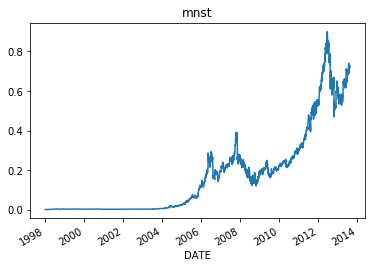

In [403]:
sd.plot_stock("mnst", rel=True)

This shows the Monster stock in absolute units.  Since the Quant Quote data does not provide the market cap in 2013, I simply assume that the 2018 market cap (from the Fidelity website) equals the final market cap in this series, and calculate the rest of the series from that assumption.  Notice that the shape of the series is the same, whether in absolute or relative units.

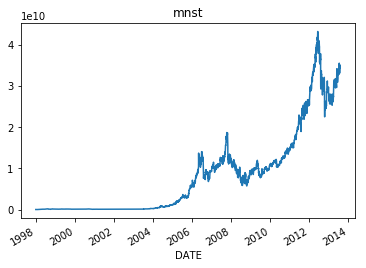

In [404]:
sd.plot_stock("mnst", rel = False)

Let's look at Monster's sector.  It seems that Monster is a "Consumer Staples" company.  This information comes from the Fidelity website.

In [379]:
sd.sectors['mnst']

'Consumer Staples'

The Consumer Staples sector had very good performance over the period 1998-2013.  The 2008 recession is easily visible.  In the end, it looks like Consumer Staples stocks were a bit higher than the other stocks (1.2).

['hsy', 'sjm', 'hrl', 'mo', 'cag', 'df', 'adm', 'syy', 'ko', 'tsn', 'pep', 'stz', 'pg', 'gis', 'cpb', 'mkc', 'k', 'cost', 'wmt', 'el', 'pm', 'kr', 'mdlz', 'tap', 'mnst', 'kmb', 'clx', 'avp', 'cce', 'cl']


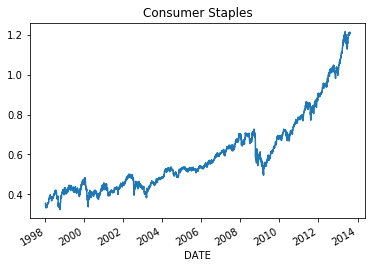

In [386]:
sd.plot_sector('Consumer Staples', rel = True)

We can see the dot com crash clearly on the Information Technology graph.  It turns out that there was a moment in the 2000 or 2001  when the average IT corporation was worth as much as it was over a decade later.  Anyone who sold at just the right time could be extremely rich.

['ca', 'glw', 'wdc', 'symc', 'txn', 'wu', 'amd', 'akam', 'acn', 'hpq', 'ffiv', 'xlnx', 'payx', 'ter', 'goog', 'fslr', 'aph', 'ea', 'msi', 'qcom', 'tdc', 'aapl', 'ntap', 'rht', 'fisv', 'adi', 'v', 'stx', 'lrcx', 'ctsh', 'tel', 'jbl', 'adp', 'mchp', 'csco', 'se', 'altr', 'adbe', 'xrx', 'tss', 'crm', 'intc', 'ibm', 'ebay', 'orcl', 'mu', 'fis', 'intu', 'adsk', 'jnpr', 'flir', 'ma', 'klac', 'msft', 'amat', 'vrsn', 'ctxs', 'nvda']


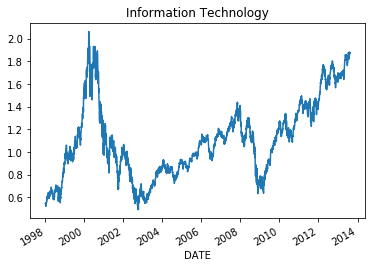

In [408]:
sd.plot_sector('Information Technology', rel = True)

Many of the functions take a "sector" keyword.  We can draw the caps vs. hits graph using Consumer Staples alone.

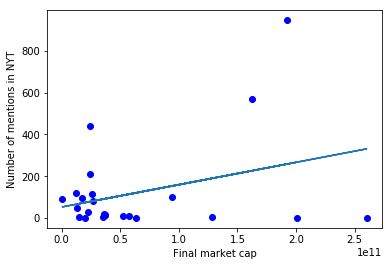

In [405]:
sd.plot_caps_vs_hits(sector = 'Consumer Staples')

What are those high market cap companies?  It looks like Walmart Inc. is huge and is never mention in the NYT website.  That's presumably due to Walmart changing its official name:

"Walmart is taking the word "stores" out of its name. The company announced Wednesday that it's changing its official name from Wal-Mart Stores, Inc., to Walmart Inc., effective February 1, 2018"

http://www.businessinsider.com/walmart-changes-its-name-2017-12

This means that the old 1998-2013 NYT pages would refer to it as "Wal-Mart Stores Inc" in the meta-data while Fidelity tells me to search for just "Walmart Inc".

To do better than this, I would need better data about the way in which NYT refers to companies, including historical name changes for all of them.  In general, this is a complex problem, since companies can be referred to in different ways.

We can, however, see that Coca Cola and Pepsico are picked up by the search, with over 500 hits on the New York Times for each.

In [410]:
sd.print_table(sortby = 1, sector = 'Consumer Staples', reverse = True)

Stock, market cap, relative market cap, growth ratio, hits
wmt: WALMART INC:  260230000000.00003 5.184293031705077 4.882344339112799 0
pg: PROCTER AND GAMBLE CO:  201240000000.0 4.00909629827587 2.91613216749983 0
ko: COCA COLA COMPANY:  192550000000.0 3.835974419762566 1.7047794102040554 947
pep: PEPSICO INC:  162480000000.0 3.236920922996737 3.231877225460998 571
pm: PHILIP MORRIS INTERNATIONAL INC:  127980000000.0 2.5496131199232055 2.197510858711623 4
mo: ALTRIA GROUP INC:  108540000000.0 2.16233011436525 7.6002709007449765 None
cost: COSTCO WHOLESALE CORPORATION:  94290000000.0 1.8784421087479217 6.267149658904808 98
mdlz: MONDELEZ INTERNATIONAL INC:  63180000000.0 1.2586697680633545 2.2006397128826123 1
cl: COLGATE PALMOLIVE CO:  57190000000.0 1.1393371958775442 4.4514566669112785 10
el: ESTEE LAUDER COMPANIES INC:  52190000000.0 1.0397273693451483 6.0494309356634846 9
kmb: KIMBERLY CLARK CORP:  37190000000.0 0.7408978897479607 3.182676936491789 12
syy: SYSCO CORP:  37030000000.0